## Analysis after model training

- Plot training and validation loss, accuracy, precision, recall, f1, curves.
- Visualize some correctly and incorrectly classified images.
- Use Grad-CAM or similar techniques to interpret model predictions. # To be done

In [53]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import sys
import torch
import torchvision.transforms as transforms
from PIL import Image

In [59]:

# Load the JSON file
file_path = "../results/temp_training_log_20250112-181355.json"
with open(file_path, 'r') as f:
    data = json.load(f)

# Convert lists to DataFrame for plotting
df = pd.DataFrame(data)
df

,train_loss,train_precision,train_recall,train_f1,train_accuracy,train_auc,train_confusion_matrix,val_loss,val_precision,val_recall,val_f1,val_accuracy,val_auc,val_confusion_matrix
0,0.223187,0.908999,0.911765,0.910380,0.913701,0.969903,"[[1950, 180], [174, 1798]]",0.335374,0.998043,0.796875,0.886186,0.850627,0.990427,"[[236, 1], [130, 510]]"
1,0.146767,0.944954,0.950461,0.947700,0.947343,0.985954,"[[1929, 114], [102, 1957]]",0.310766,0.989324,0.868750,0.925125,0.897377,0.987803,"[[231, 6], [84, 556]]"
2,0.142753,0.946588,0.942857,0.944719,0.945392,0.986982,"[[1964, 108], [116, 1914]]",0.528981,0.991684,0.745313,0.851026,0.809578,0.985245,"[[233, 4], [163, 477]]"
3,0.114924,0.960236,0.952288,0.956245,0.956363,0.991509,"[[1967, 81], [98, 1956]]",0.386079,0.994465,0.842187,0.912014,0.881414,0.985799,"[[234, 3], [101, 539]]"


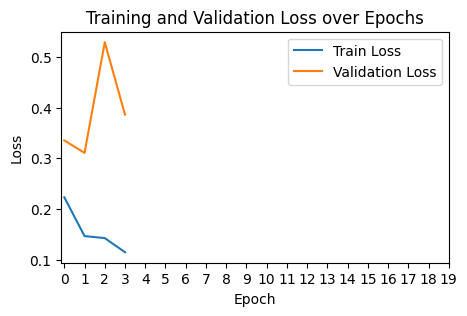

In [65]:

# Plot Loss
plt.figure(figsize=(5, 3))
plt.plot(df['train_loss'], label='Train Loss')
plt.plot(df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, 20, step=1))
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

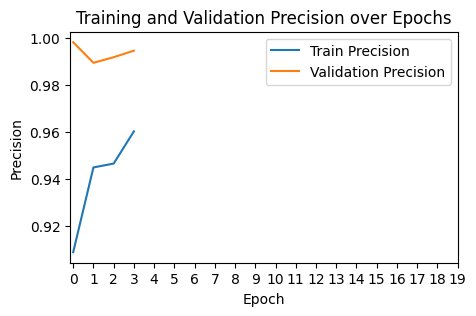

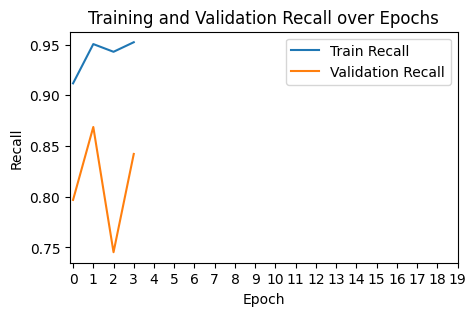

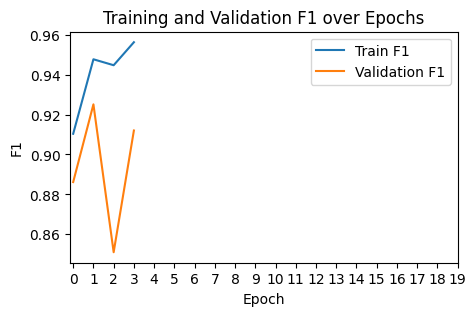

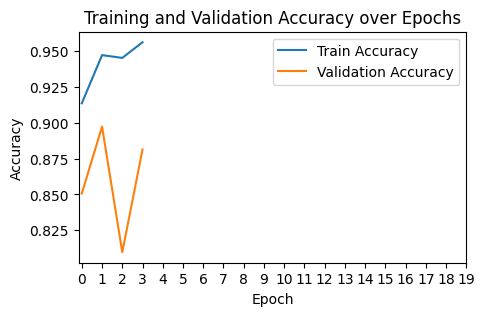

In [64]:
# Plot Precision, Recall, F1, and Accuracy
metrics = ['precision', 'recall', 'f1', 'accuracy']
for metric in metrics:
    plt.figure(figsize=(5, 3))
    plt.plot(df[f'train_{metric}'], label=f'Train {metric.capitalize()}')
    plt.plot(df[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
    plt.xlabel('Epoch')
    plt.xticks(np.arange(0, 20, step=1))
    plt.ylabel(metric.capitalize())
    plt.title(f'Training and Validation {metric.capitalize()} over Epochs')
    plt.legend()
    plt.show()

## Confusion matrices train|val

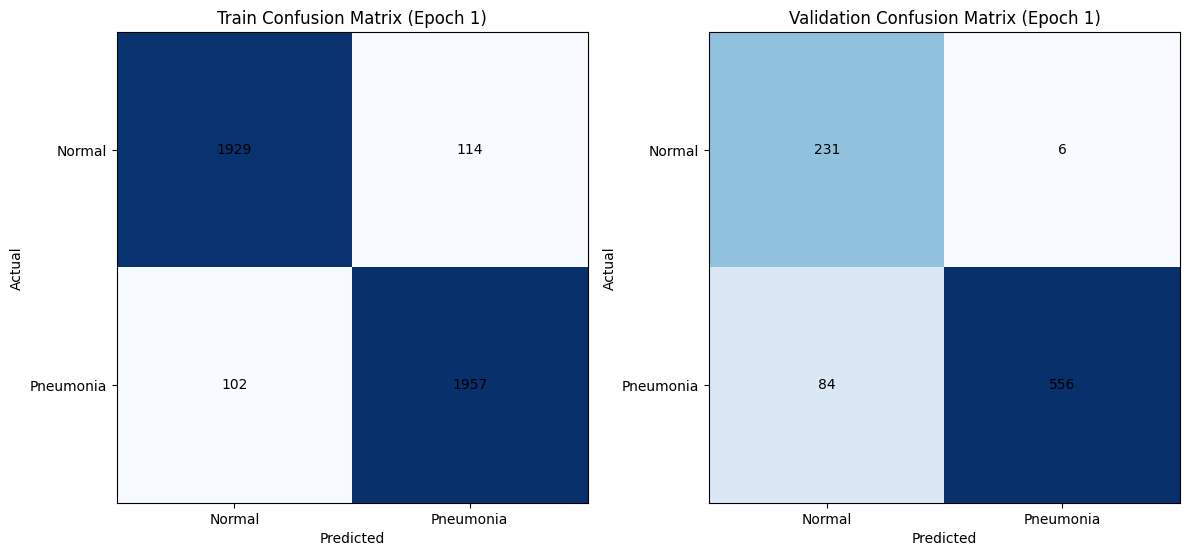

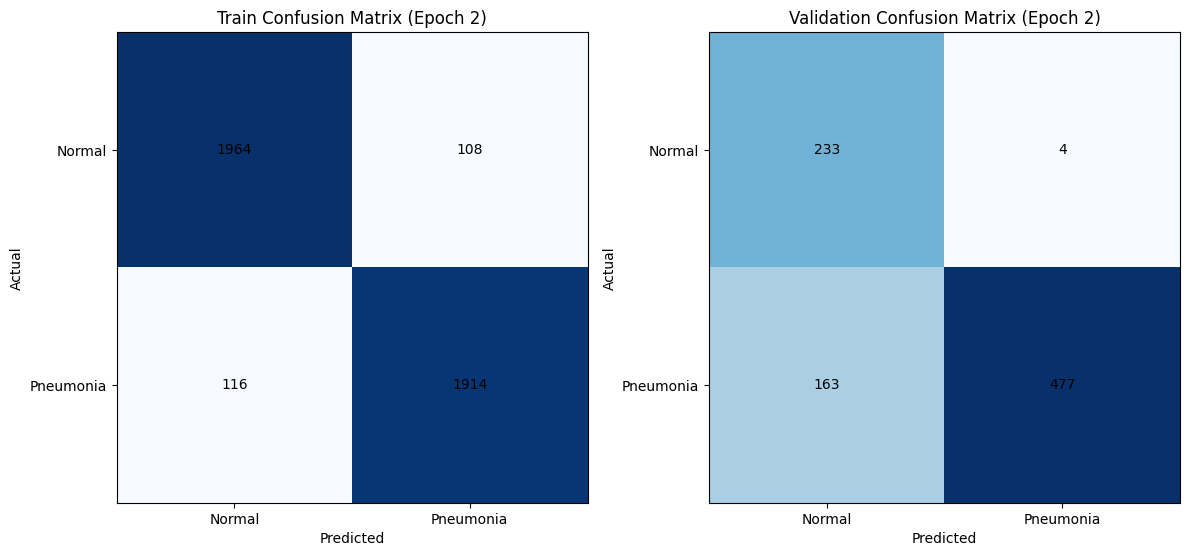

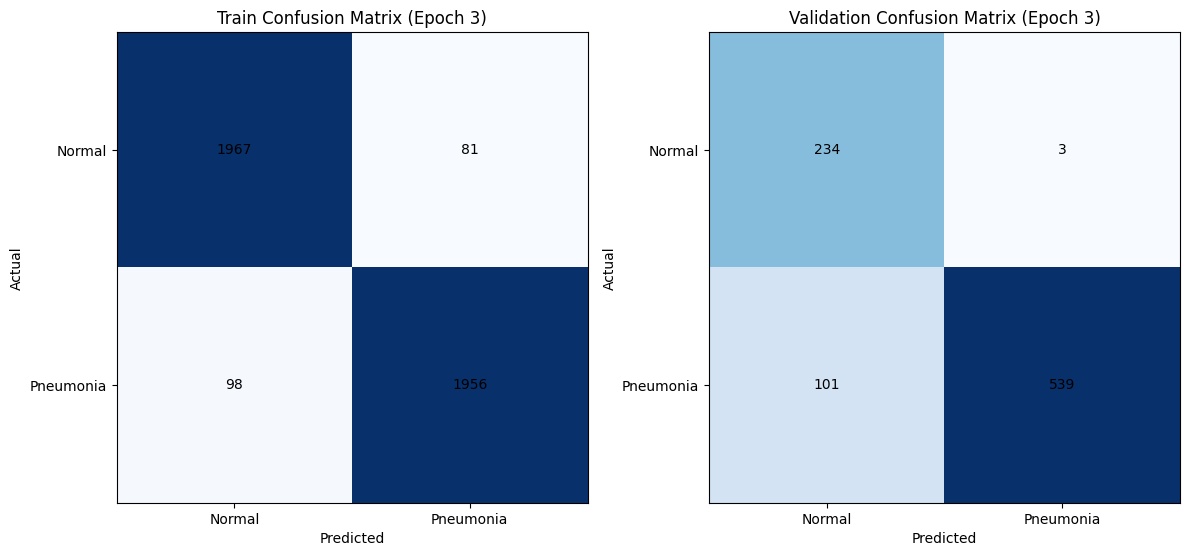

In [66]:
# Extract train and validation confusion matrices (NOTE: last three epochs)
train_conf_matrices = data['train_confusion_matrix'][-3:]
val_conf_matrices = data['val_confusion_matrix'][-3:]

# Function to plot a pair of confusion matrices side by side with labels
def plot_confusion_matrices(train_cm, val_cm, epoch):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create side-by-side plots
    class_names = ["Normal", "Pneumonia"]

    # Plot Train Confusion Matrix
    axes[0].imshow(train_cm, cmap='Blues')
    axes[0].set_title(f'Train Confusion Matrix (Epoch {epoch})')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_xticks([0, 1])
    axes[0].set_xticklabels(class_names)
    axes[0].set_yticks([0, 1])
    axes[0].set_yticklabels(class_names)
    
    # Annotate Train Confusion Matrix
    for (i, j), val in np.ndenumerate(train_cm):
        axes[0].text(j, i, f'{val}', ha='center', va='center')

    # Plot Validation Confusion Matrix
    axes[1].imshow(val_cm, cmap='Blues')
    axes[1].set_title(f'Validation Confusion Matrix (Epoch {epoch})')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    axes[1].set_xticks([0, 1])
    axes[1].set_xticklabels(class_names)
    axes[1].set_yticks([0, 1])
    axes[1].set_yticklabels(class_names)

    # Annotate Validation Confusion Matrix
    for (i, j), val in np.ndenumerate(val_cm):
        axes[1].text(j, i, f'{val}', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

# Plot train and validation confusion matrices side by side for each epoch
for i, (train_cm, val_cm) in enumerate(zip(train_conf_matrices, val_conf_matrices), 1):
    train_cm = np.array(train_cm)
    val_cm = np.array(val_cm)
    plot_confusion_matrices(train_cm, val_cm, epoch=i)


In [67]:
# Add parent directory to Python path
sys.path.append("C:/Users/glajusj/Documents/github/PneumoScope")

# Import PneumoNet from model.py
from src.model import PneumoNet

# Load the checkpoint
checkpoint_path = "../saved_models/best_model_20250112-015744.pth"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'), weights_only=False)

# Initialize the model with num_classes=1 for binary classification
model = PneumoNet(num_classes=1)  # num_classes=1 because the checkpoint was saved with a single output

# Load the model state_dict from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

# Define the same preprocessing as in data_loader.py
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Paths to directories
pneumonia_dir = "../data/val/PNEUMONIA"
normal_dir = "../data/val/NORMAL"

# Randomly select 5 images from each class
num_images_per_class = 5
pneumonia_images = random.sample(os.listdir(pneumonia_dir), num_images_per_class)
normal_images = random.sample(os.listdir(normal_dir), num_images_per_class)

# Combine and create full paths
image_paths = [os.path.join(pneumonia_dir, img) for img in pneumonia_images] + \
              [os.path.join(normal_dir, img) for img in normal_images]

# Perform inference on each image
class_labels = {0: "NORMAL", 1: "PNEUMONIA"}  # 0 = NORMAL, 1 = PNEUMONIA
for image_path in image_paths:
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    
    # Get the model's prediction
    with torch.no_grad():
        output = model(input_tensor)
        probability = torch.sigmoid(output).item()  # Apply sigmoid to get probability
        predicted_class = 1 if probability >= 0.5 else 0  # Threshold at 0.5
    
    # Print the result
    print(f"Image: {os.path.basename(image_path)} -> Predicted: {class_labels[predicted_class]} (Probability: {probability:.2f})")

Image: person34_bacteria_176.jpeg -> Predicted: PNEUMONIA (Probability: 0.87)
Image: person844_virus_1487.jpeg -> Predicted: NORMAL (Probability: 0.46)
Image: person545_bacteria_2290.jpeg -> Predicted: PNEUMONIA (Probability: 0.98)
Image: person1372_bacteria_3498.jpeg -> Predicted: PNEUMONIA (Probability: 1.00)
Image: person434_virus_884.jpeg -> Predicted: PNEUMONIA (Probability: 1.00)
Image: NORMAL2-IM-1164-0001.jpeg -> Predicted: NORMAL (Probability: 0.00)
Image: IM-0766-0001.jpeg -> Predicted: NORMAL (Probability: 0.00)
Image: NORMAL2-IM-0941-0001.jpeg -> Predicted: NORMAL (Probability: 0.03)
Image: NORMAL2-IM-0395-0001-0002.jpeg -> Predicted: NORMAL (Probability: 0.02)
Image: IM-0308-0001.jpeg -> Predicted: NORMAL (Probability: 0.02)


In [68]:
# Access the saved metrics
epoch = checkpoint.get('epoch', 'Unknown')  # Epoch number at which the checkpoint was saved
history = checkpoint.get('history', {})  # Training/validation history over epochs
metrics = checkpoint.get('metrics', None)  # Final metrics summary

# Summarize the training/validation history
if history:
    print(f"Checkpoint saved at epoch: {epoch}")
    print("Training/validation history summary:")
    
    # Convert history to a DataFrame for better visualization
    df_history = pd.DataFrame(history)
    print(df_history.describe().transpose())  # Show summary statistics for each metric
else:
    print("No training/validation history available.")

# Display the final metrics summary
if metrics:
    print("\nFinal metrics summary:")
    for key, value in metrics.items():
        if isinstance(value, (list, tuple)):  # Check if the value is a list or tuple
            value = ", ".join(f"{v:.4f}" for v in value)  # Format each item in the list
            print(f"{key}: [{value}]")
        else:  # Handle scalar values
            print(f"{key}: {value:.4f}")
else:
    print("No metrics summary available.")


Checkpoint saved at epoch: 6
Training/validation history summary:
                 count      mean       std       min       25%       50%  \
train_loss         6.0  0.131848  0.034689  0.102074  0.109209  0.120263   
train_precision    6.0  0.963835  0.009561  0.948247  0.959136  0.965962   
train_recall       6.0  0.967313  0.009510  0.948881  0.968343  0.968760   
train_f1           6.0  0.965565  0.009219  0.948564  0.963716  0.968118   
train_accuracy     6.0  0.949659  0.013463  0.924915  0.946794  0.953437   
train_auc          6.0  0.985084  0.008127  0.969673  0.983899  0.988152   
val_loss           6.0  0.144731  0.059857  0.077441  0.109387  0.132692   
val_precision      6.0  0.956350  0.030457  0.905233  0.941612  0.969756   
val_recall         6.0  0.969792  0.035004  0.903125  0.968750  0.976562   
val_f1             6.0  0.962226  0.013752  0.941368  0.953618  0.966294   
val_accuracy       6.0  0.944508  0.019772  0.917902  0.929019  0.949829   
val_auc            6.0

# Interpretation of AUC
- AUC = 1.0: Perfect model that correctly classifies all positive and negative instances.
- AUC = 0.5: A model that performs no better than random guessing.
- AUC > 0.9: Excellent performance.
- AUC between 0.7 and 0.9: Good performance.
- AUC < 0.7: Poor performance.